In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import time 
import matplotlib.pyplot as plt
import importlib
import kornia as K
from torchvision import transforms, datasets
from torch.utils.data import  TensorDataset, DataLoader
from torch.distributions import Normal
import pandas as pd
device = 'cuda'
%cd C:\Users\Admin\Documents\Python-projects\SCCL_project\SCCL


C:\Users\Admin\Documents\Python-projects\SCCL_project\SCCL


In [38]:
# ord
# chr

name = 'phamquanghieu'
# name = 'nguyentriquan'

code = []
for c in name:
    i = ord(c) - ord('a')
    code.append(i%9+1)

print(code)
while len(code) > 1:
    code = sum(code)
    code = str(code)
    code = [int(c) for c in code]
    print(code)

[7, 8, 1, 4, 8, 3, 1, 5, 7, 8, 9, 5, 3]
[6, 9]
[1, 5]
[6]


In [33]:

x = torch.rand(5)

a = torch.rand(3, 5)
b = torch.rand(3, 3)
c = torch.rand(4, 3)

d = torch.rand(4, 5)

f = torch.rand(1, 4)

out = torch.matmul(a, x)
out = torch.matmul(b, out)
out = torch.matmul(c, out)
out += torch.matmul(d, x)
out = torch.matmul(f, out)


print(out)

norm1 = c.norm(2, dim=1)
norm2 = d.norm(2, dim=1)

v1, i1 = norm1.sort(descending=True)
v2, i2 = norm2.sort(descending=True)

mask1 = norm1 >= v1[2]
mask2 = norm2 >= v2[1]
print(mask1, mask2)
mask = torch.logical_or(mask1, mask2)

d = d[mask]
c = c[mask]
f = f[:, mask]

out = torch.matmul(a, x)
out = torch.matmul(b, out)
out = torch.matmul(c, out)
out += torch.matmul(d, x)
out = torch.matmul(f, out)

print(out)


tensor([5.4023])
tensor([ True,  True,  True, False]) tensor([ True, False,  True, False])
tensor([3.5000])


In [58]:
b = torch.rand(3) > 0.5
d = torch.rand(3) > 0.5

a = b
c = a
print(a,d)
a += d

print(a, b, c)

a = a + (torch.rand(3) > 0.5)
print(a, b, c)


tensor([False, False, False]) tensor([False, False,  True])
tensor([False, False,  True]) tensor([False, False,  True]) tensor([False, False,  True])
tensor([ True, False,  True]) tensor([False, False,  True]) tensor([False, False,  True])


In [16]:
a = torch.rand(3, 3)

b = a.clone()
print(a, b)

b *= 2

print(a, b)

tensor([[0.0659, 0.8039, 0.4350],
        [0.3231, 0.8776, 0.0428],
        [0.9610, 0.7056, 0.7083]]) tensor([[0.0659, 0.8039, 0.4350],
        [0.3231, 0.8776, 0.0428],
        [0.9610, 0.7056, 0.7083]])
tensor([[0.0659, 0.8039, 0.4350],
        [0.3231, 0.8776, 0.0428],
        [0.9610, 0.7056, 0.7083]]) tensor([[0.1319, 1.6078, 0.8700],
        [0.6462, 1.7552, 0.0856],
        [1.9221, 1.4113, 1.4166]])


Files already downloaded and verified
tensor([[[[ 2.0587,  2.0587,  2.0587,  ...,  1.1063,  1.3762,  0.9000],
          [ 2.0587,  2.0429,  2.0429,  ...,  0.7095,  0.5667,  0.3286],
          [ 2.0587,  2.0429,  2.0587,  ...,  1.0111,  0.6460, -0.0683],
          ...,
          [ 0.3603,  0.2651,  0.2333,  ..., -1.5127, -0.9571, -0.7825],
          [-0.0524, -0.0841,  0.0111,  ..., -1.6397, -0.4492,  0.2492],
          [-0.6079, -0.5921, -0.3857,  ..., -1.4492, -0.3222,  0.2016]],

         [[ 2.1256,  2.1256,  2.1256,  ...,  1.3205,  1.6264,  1.1433],
          [ 2.1256,  2.1095,  2.1095,  ...,  0.8535,  0.7246,  0.4992],
          [ 2.1256,  2.1095,  2.1256,  ...,  1.2238,  0.8857,  0.1610],
          ...,
          [ 0.9984,  0.9501,  0.9018,  ..., -1.7069, -0.9823, -0.7407],
          [ 0.5475,  0.5153,  0.5958,  ..., -1.7230, -0.1771,  0.6119],
          [-0.0161, -0.0161,  0.1771,  ..., -1.4010,  0.1610,  0.8052]],

         [[ 2.1154,  2.1154,  2.1154,  ...,  1.1859,  1.3508,  0

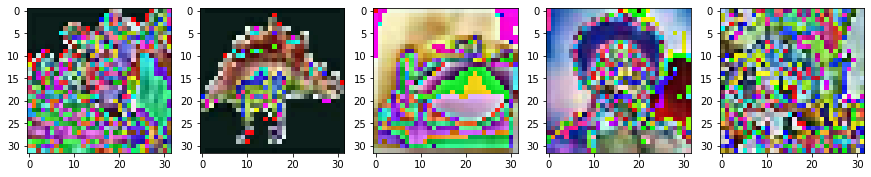

In [15]:
mean=[x/255 for x in [125.3,123.0,113.9]]
std=[x/255 for x in [63.0,62.1,66.7]]
trainset = datasets.CIFAR100('../dat/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
loader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=False)
to_img = transforms.ToPILImage()
for image,target in loader:
   print(image)
   fig, axs = plt.subplots(1, 5, figsize=(15, 3))
   for i, img in enumerate(image):
      axs[i].imshow(to_img(img))
   break

In [3]:
data = {}
trainset = datasets.CIFAR100('../dat/', train=True, download=True)
testset = datasets.CIFAR100('../dat/', train=False, download=True)
for t in range(10):
    data[t] = {}
    labels = torch.tensor(trainset.targets)
    images = torch.tensor(trainset.data).permute(0, 3, 1, 2)/255.0
    print(images.shape)
    ids = labels//10 == t
    # print(labels[ids])
    data[t]['train_set'] = TensorDataset(images[ids], labels[ids]%10)
    data[t]['train_loader'] = DataLoader(data[t]['train_set'], batch_size=5, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])


c:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == '__main__':


torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])


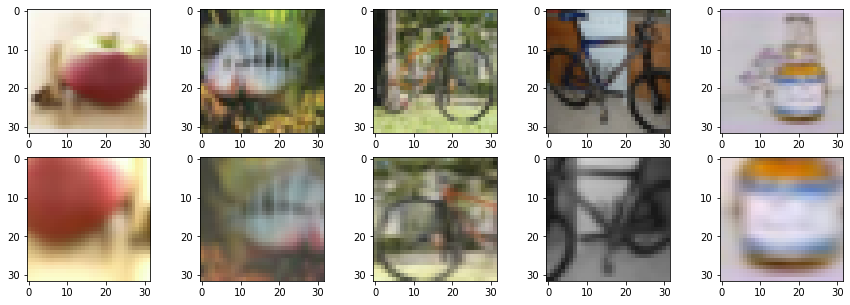

In [7]:

mean=torch.tensor([x/255 for x in [125.3,123.0,113.9]])
std=torch.tensor([x/255 for x in [63.0,62.1,66.7]])

# train_transform = torch.nn.Sequential(
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.Normalize(mean=mean, std=std),
# )
# train_transform = torch.nn.Sequential(
#     K.augmentation.RandomCrop(size=(32, 32), padding=4, same_on_batch=False),
#     K.augmentation.RandomHorizontalFlip(),
#     K.augmentation.Normalize(mean=mean, std=std),
# )

train_transform = torch.nn.Sequential(
        K.augmentation.RandomResizedCrop(size=(32, 32), scale=(0.2, 1.0), same_on_batch=False),
        K.augmentation.RandomHorizontalFlip(),
        K.augmentation.ColorJitter(0.4, 0.4, 0.4, 0.1, p=0.8, same_on_batch=False),
        K.augmentation.RandomGrayscale(p=0.2),
        # K.augmentation.Normalize(mean, std),
    )
to_img = transforms.ToPILImage()
for x, y in data[0]['train_loader']:
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    for i, img in enumerate(x):
        axs[0][i].imshow(to_img(img))

    # print((x[0]-mean.view(1, -1, 1, 1))/std.view(1, -1, 1, 1))
    x = train_transform(x)
    # print(x[0])
    for i, img in enumerate(x):
        axs[1][i].imshow(to_img(img))
    break

In [13]:
a = torch.rand(10, 3)
v, i  = a.norm(2, dim=1).sort(descending=True)
a[i[5:]] = 0

b = torch.rand(10, 10)
b[:, i[5:]] = 0
v, i  = b.norm(2, dim=1).sort(descending=True)
b[i[6:]] = 0

c = torch.rand(10, 10)
c[:, i[6:]] = 0
v, i  = c.norm(2, dim=1).sort(descending=True)
c[i[7:]] = 0

d = torch.rand(2, 10)
d[:, i[7:]] = 0

x = torch.rand(3)
y = torch.matmul(a, x)
print(y)
y = torch.matmul(b, y) + y
print(y)
y = torch.matmul(c, y) + y
print(y)
y = torch.matmul(d, y)
print(y)
print()

v, i  = a.norm(2, dim=1).sort(descending=True)
i = i[:5]
a = a[i]
b = b[i][:, i]
c = c[:, i]

# print(a.shape, b.shape, c.shape)
# v, i  = b.norm(2, dim=1).sort(descending=True)
# b = b[i]
# c = c[i][:, i]
# d = d[:, i]


# v, i  = c.norm(2, dim=1).sort(descending=True)
# c = c[i]
# d = d[:, i]

# y = torch.matmul(a, x)
# y_ = torch.matmul(b, y)
# y_[:5] += y
# y = y_

# y_ = torch.matmul(c, y)
# y_[:6] += y
# y = y_

# y = torch.matmul(d, y)

y = torch.matmul(a, x)
print(y)
y = torch.matmul(b, y) + y
print(y)
y = torch.matmul(c, y) + y
print(y)
y = torch.matmul(d, y)
print(y)


tensor([0.0000, 0.8944, 0.0000, 0.8377, 0.8183, 0.0000, 0.5826, 0.0000, 1.1480,
        0.0000])
tensor([0.0000, 3.0954, 2.1212, 3.5637, 0.8183, 2.3999, 3.3242, 2.5178, 1.1480,
        0.0000])
tensor([11.2406, 13.2462,  2.1212, 13.7734,  9.5550, 10.4809, 14.0110,  2.5178,
         1.1480,  9.4021])
tensor([59.9290, 47.8016])

tensor([1.1480, 0.8944, 0.8183, 0.8377, 0.5826, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([1.1480, 3.0954, 0.8183, 3.5637, 3.3242, 0.0000, 2.1212, 2.3999, 2.5178,
        0.0000])
tensor([12.3886, 13.2462,  0.8183, 13.7734, 12.0609,  8.0810, 12.8080,  2.3999,
         2.5178,  9.4021])
tensor([60.0708, 48.6298])


In [47]:
%cd C:\Users\Admin\Documents\Python-projects\SCCL_project\SCCL
# name = 'split_cifar100_sccl_VGG8_0_lamb_0.015_0.015_lr_0.001_batch_32_epoch_100_optim_Adam_fix_False_norm_bn.model'
name = 'split_cifar100_sccl_VGG8_0_lamb_0.015_lr_0.001_batch_32_epoch_100_optim_Adam_fix_False_norm_bn.model'
dir = 'C:\\Users\\Admin\\Documents\\Python-projects\\SCCL_project\\result_data\\trained_model\\'

model = torch.load(dir+name)['model']
s_H = model.s_H()
print('s_H={:.1e}'.format(s_H))
t = 1
model.get_params(t-1)
count = 1
for i, m in enumerate(model.DM):
    weight = torch.cat([torch.cat([m.old_weight, m.fwt_weight[t]], dim=0), torch.cat([m.bwt_weight[t], m.weight[t]], dim=0)], dim=1)
    norm = weight.norm(2).detach()
    # norm = s_H
    m.weight[t].data /= 10
    if m.bias:
        m.bias[t].data /= 10
    
    if m.norm_layer:
        if m.norm_layer.track_running_stats:
            m.norm_layer.running_mean[t].data /= (10*(i+1))
            m.norm_layer.running_var[t].data /= (10**2 * (i+1))
        # if m.norm_layer.affine:
        #     m.norm_layer.weight[t].data /= 10
        #     m.norm_layer.bias[t].data /= 10
s_H = model.s_H()
print('s_H={:.1e}'.format(s_H))

C:\Users\Admin\Documents\Python-projects\SCCL_project\SCCL
s_H=5.5e+04
s_H=5.5e-03


In [5]:
class Appr(object):

    def __init__(self,model,args=None,thres=1e-3,lamb='0',nepochs=100,batch_size=256,val_batch_size=256,
                lr=0.001,lr_min=1e-5,lr_factor=3,lr_patience=5,clipgrad=10,optim='Adam',tasknum=1,fix=False, experiment=None, approach=None, arch=None, seed=0):
        self.model=model

        self.nepochs = nepochs
        self.batch_size = batch_size
        self.val_batch_size = val_batch_size
        self.lr = lr
        self.lr_min = lr/100
        self.lr_factor = lr_factor
        self.lr_patience = lr_patience 
        self.clipgrad = clipgrad
        self.optim = optim
        self.thres = thres
        self.tasknum = tasknum
        self.fix = fix
        self.experiment = experiment
        self.approach = approach
        self.arch = arch
        self.seed = seed

        self.lambs = [float(i) for i in lamb.split('_')]
        self.check_point = None
        
        if len(self.lambs) < self.tasknum:
            self.lambs = [self.lambs[-1] if i>=len(self.lambs) else self.lambs[i] for i in range(args.tasknum)]

        print('lambs:', self.lambs)

        self.ce = torch.nn.CrossEntropyLoss()
        self.optimizer = self._get_optimizer()
        self.shape_out = self.model.layers[-1].shape_out
        self.cur_task = len(self.shape_out)-1

        
    def resume(self):
        for t in range(1, self.tasknum + 1):
            try:
                self.log_name = '{}_{}_{}_{}_lamb_{}_lr_{}_batch_{}_epoch_{}_optim_{}_fix_{}'.format(self.experiment, self.approach, self.arch, self.seed,
                                                                                '_'.join([str(lamb) for lamb in self.lambs[:t]]),  
                                                                                self.lr, self.batch_size, self.nepochs, self.optim, self.fix)

                self.check_point = torch.load(f'../result_data/trained_model/{self.log_name}.model')
                self.model = self.check_point['model']
                print('Resume from task', t-1)

                return t-1
            except:
                continue
        return 0

    def _get_optimizer(self,lr=None):
        if lr is None: lr=self.lr

        params = self.model.get_optim_params()

        if self.optim == 'SGD':
            return torch.optim.SGD(params, lr=lr,
                          weight_decay=0.0, momentum=0.9, nesterov=True)
        if self.optim == 'Adam':
            return torch.optim.Adam(params, lr=lr)

    def train(self, t, train_loader, valid_loader, ncla=0):

        if self.check_point is None:
            print('Training new task')

            self.model.expand(ncla)

            self.shape_out = self.model.layers[-1].shape_out
            self.cur_task = len(self.shape_out)-1

            self.check_point = {'model':self.model, 'squeeze':True, 'optimizer':self._get_optimizer(), 'epoch':-1, 'lr':self.lr, 'patience':self.lr_patience}

            try:
                os.remove(f'../result_data/trained_model/{self.log_name}.model')
            except:
                pass
            self.log_name = '{}_{}_{}_{}_lamb_{}_lr_{}_batch_{}_epoch_{}_optim_{}_fix_{}'.format(self.experiment, self.approach, self.arch, self.seed,
                                                                                '_'.join([str(lamb) for lamb in self.lambs[:t]]),  
                                                                                self.lr, self.batch_size, self.nepochs, self.optim, self.fix)
            torch.save(self.check_point, f'../result_data/trained_model/{self.log_name}.model')
                
            with open(f'../result_data/csv_data/{self.log_name}.csv', 'w', newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
                writer.writerow(['train loss', 'train acc', 'valid loss', 'valid acc', 'fro norm'])
        else: 
            print('Retraining current task')


        self.model.restrict_gradients(t-1, False)
        self.shape_out = self.model.layers[-1].shape_out
        self.cur_task = len(self.shape_out)-1

        self.lamb = self.lambs[self.cur_task-1]
        print('lambda', self.lamb)
        print(self.log_name)

        self.train_phase(t, train_loader, valid_loader, True)
        if not self.check_point['squeeze']:
            self.check_point = None
            return 

        self.prune(t, train_loader, thres=self.thres)


        self.check_point = {'model':self.model, 'squeeze':False, 'optimizer':self._get_optimizer(), 'epoch':-1, 'lr':self.lr, 'patience':self.lr_patience}
        torch.save(self.check_point,'../result_data/trained_model/{}.model'.format(self.log_name))

        self.train_phase(t, train_loader, valid_loader, False)

        self.check_point = None
        # self.model.get_params(t-1)
        # for m in self.model.DM:
        #     weight = torch.cat([torch.cat([m.old_weight, m.fwt_weight[t]], dim=0), torch.cat([m.bwt_weight[t], m.weight[t]], dim=0)], dim=1)
        #     norm = weight.norm(2).detach()
        #     m.weight[t].data /= norm
        #     if m.bias:
        #         m.bias[t].data /= norm

        # s_H = self.model.s_H()
        # print('s_H={:.1e}'.format(s_H), end='')
        

    def train_phase(self, t, train_loader, valid_loader, squeeze):

        print('number of neurons:', end=' ')
        for m in self.model.DM:
            print(m.out_features, end=' ')
        print()
        params = self.model.compute_model_size()
        print('num params', params)

        train_loss,train_acc=self.eval(t,train_loader)
        print('| Train: loss={:.3f}, acc={:5.2f}% |'.format(train_loss,100*train_acc), end='')

        valid_loss,valid_acc=self.eval(t,valid_loader)
        print(' Valid: loss={:.3f}, acc={:5.2f}% |'.format(valid_loss,100*valid_acc))

        lr = self.check_point['lr']
        patience = self.check_point['patience']
        self.optimizer = self.check_point['optimizer']
        start_epoch = self.check_point['epoch'] + 1
        squeeze = self.check_point['squeeze']

        if squeeze:
            best_acc = train_acc
        else:
            best_acc = valid_acc
    
        try:
            for e in range(start_epoch, self.nepochs):
                clock0=time.time()
                self.train_epoch(t, train_loader, squeeze)
            
                clock1=time.time()
                train_loss,train_acc=self.eval(t, train_loader)
                clock2=time.time()
                print('| Epoch {:3d}, time={:5.1f}ms/{:5.1f}ms | Train: loss={:.3f}, acc={:5.2f}% |'.format(
                    e+1,1000*(clock1-clock0),
                    1000*(clock2-clock1),train_loss,100*train_acc),end='')

                valid_loss,valid_acc=self.eval(t, valid_loader)
                print(' Valid: loss={:.3f}, acc={:5.2f}% |'.format(valid_loss,100*valid_acc),end='')
                
                s_H = self.model.s_H()
                print('s_H={:.1e}'.format(s_H), end='')
                # Adapt lr
                if squeeze:
                    if train_acc >= best_acc:
                        best_acc = train_acc
                        self.check_point = {'model':self.model, 'optimizer':self.optimizer, 'squeeze':squeeze, 'epoch':e, 'lr':lr, 'patience':patience}
                        torch.save(self.check_point,'../result_data/trained_model/{}.model'.format(self.log_name))
                        print(' *', end='')
                        patience = self.lr_patience

                else:
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        self.check_point = {'model':self.model, 'optimizer':self.optimizer, 'squeeze':squeeze, 'epoch':e, 'lr':lr, 'patience':patience}
                        torch.save(self.check_point,'../result_data/trained_model/{}.model'.format(self.log_name))
                        patience = self.lr_patience
                        print(' *', end='')
                    else:
                        patience -= 1
                        if patience <= 0:
                            lr /= self.lr_factor
                            print(' lr={:.1e}'.format(lr), end='')
                            if lr < self.lr_min:
                                print()
                                break
                                
                            patience = self.lr_patience
                            self.optimizer = self._get_optimizer(lr)

                print()
                with open(f'../result_data/csv_data/{self.log_name}.csv', 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    writer.writerow([train_loss, train_acc, valid_loss, valid_acc, s_H])

        except KeyboardInterrupt:
            print('KeyboardInterrupt')
            self.check_point = torch.load('../result_data/trained_model/{}.model'.format(self.log_name))
            self.model = self.check_point['model']
            self.model.to(device)

        self.check_point = torch.load('../result_data/trained_model/{}.model'.format(self.log_name))
        self.model = self.check_point['model']

    def train_batch(self, t, images, targets, squeeze):
        outputs = self.model.forward(images, t=t)
        outputs = outputs[:, self.shape_out[t-1]:self.shape_out[t]]

        loss = self.ce(outputs, targets)

        if squeeze:
            loss += self.model.group_lasso_reg() * self.lamb
                
        self.optimizer.zero_grad()
        loss.backward() 

        self.optimizer.step()

    def eval_batch(self, t, images, targets):
        if t is None:
            outputs = []
            entropy = []
            aug_images = [images]
            batch_DA = 32
            for n in range(batch_DA):
                aug_images.append(self.trans(images))
            aug_images = torch.cat(aug_images, dim=0)
            for task in range(1, self.cur_task + 1):
                self.model.get_params(task-1)
                output = self.model.forward(aug_images, t=task)[:, self.shape_out[task-1]:self.shape_out[task]]
                output = output.reshape(batch_DA+1, len(targets), -1)
                # output = F.softmax(output, dim=-1)
                output = F.softplus(output)
                output = output / output.sum(-1).unsqueeze(-1)
                outputs.append(output[0])
                entropy.append(-(output*output.log()).sum((-1, 0)))

            entropy = torch.stack(entropy, dim=1)
            outputs = torch.stack(outputs, dim=1)
            v, i = entropy.min(1)
            outputs = outputs[range(outputs.shape[0]), i]
        else:
            self.model.get_params(t-1)
            outputs = self.model.forward(images, t=t)
            outputs = outputs[:, self.shape_out[t-1]:self.shape_out[t]]
                        
        loss=self.ce(outputs,targets)
        values,indices=outputs.max(1)
        hits=(indices==targets).float()

        return loss.data.cpu().numpy()*len(targets), hits.sum().data.cpu().numpy()

    def train_epoch(self, t, data_loader, squeeze=True):
        self.model.train()
        self.model.get_params(t-1)
        for images, targets in data_loader:
            images=images.to(device)
            targets=targets.to(device)
            self.train_batch(t, images, targets, squeeze)


    def eval(self, t, data_loader):
        total_loss=0
        total_acc=0
        total_num=0
        self.model.eval()

        for images, targets in data_loader:
            images=images.to(device)
            targets=targets.to(device)
                    
            loss, hits = self.eval_batch(t, images, targets)
            total_loss += loss
            total_acc += hits
            total_num += len(targets)
                
        return total_loss/total_num,total_acc/total_num


    def prune(self, t, data_loader, thres=0.0):

        fig, axs = plt.subplots(3, len(self.model.DM)-1, figsize=(3*len(self.model.DM)-3, 9))
        for i, m in enumerate(self.model.DM[:-1]):
            axs[0][i].hist(m.norm_in().detach().cpu().numpy(), bins=100)
            axs[0][i].set_title(f'layer {i+1}')

            axs[1][i].hist(m.norm_out().detach().cpu().numpy(), bins=100)
            axs[1][i].set_title(f'layer {i+1}')

            axs[2][i].hist((m.norm_in()*m.norm_out()).detach().cpu().numpy(), bins=100)
            axs[2][i].set_title(f'layer {i+1}')

        plt.show()

        loss,acc=self.eval(t,data_loader)
        loss, acc = round(loss, 3), round(acc, 3)
        print('Pre Prune: loss={:.3f}, acc={:5.2f}% |'.format(loss,100*acc))
        # pre_prune_acc = acc
        pre_prune_loss = loss
        prune_ratio = np.ones(len(self.model.DM)-1)
        step = 0
        pre_sum = 0
        # Dynamic expansion
        while True:
            t1 = time.time()
            fig, axs = plt.subplots(1, len(self.model.DM)-1, figsize=(3*len(self.model.DM)-3, 2))
            print('Pruning ratio:', end=' ')
            for i in range(0, len(self.model.DM)-1):
                m = self.model.DM[i]
                mask_temp = m.mask
                norm = m.get_importance()

                low = 0 
                if m.mask is None:
                    high = norm.shape[0]
                else:
                    high = int(sum(m.mask))

                axs[i].hist(norm.detach().cpu().numpy(), bins=100)
                axs[i].set_title(f'layer {i+1}')

                if norm.shape[0] != 0:
                    values, indices = norm.sort(descending=True)
                    loss,acc=self.eval(t,data_loader)
                    loss, acc = round(loss, 3), round(acc, 3)
                    pre_prune_loss = loss

                    while True:
                        k = (high+low)//2
                        # Select top-k biggest norm
                        m.mask = (norm>values[k])
                        loss, acc = self.eval(t, data_loader)
                        loss, acc = round(loss, 3), round(acc, 3)
                        # post_prune_acc = acc
                        post_prune_loss = loss
                        if  post_prune_loss <= pre_prune_loss:
                        # if pre_prune_acc <= post_prune_acc:
                            # k is satisfy, try smaller k
                            high = k
                            # pre_prune_loss = post_prune_loss
                        else:
                            # k is not satisfy, try bigger k
                            low = k

                        if k == (high+low)//2:
                            break


                if high == norm.shape[0]:
                    # not found any k satisfy, keep all neurons
                    m.mask = mask_temp
                else:
                    # found k = high is the smallest k satisfy
                    m.mask = (norm>values[high])

                # remove neurons 
                # m.squeeze()

                if m.mask is None:
                    prune_ratio[i] = 0.0
                else:
                    mask_count = int(sum(m.mask))
                    total_count = m.mask.numel()
                    prune_ratio[i] = 1.0 - mask_count/total_count

                print('{:.3f}'.format(prune_ratio[i]), end=' ')
                # m.mask = None

            fig.savefig(f'../result_data/images/{self.log_name}_task{t}_step_{step}.pdf', bbox_inches='tight')
            # plt.show()
            loss,acc=self.eval(t,data_loader)
            print('| Post Prune: loss={:.3f}, acc={:5.2f}% | Time={:5.1f}ms |'.format(loss, 100*acc, (time.time()-t1)*1000))

            step += 1
            if sum(prune_ratio) == pre_sum:
                break
            pre_sum = sum(prune_ratio)

        for m in self.model.DM[:-1]:
            m.squeeze()
            m.mask = None
        loss,acc=self.eval(t,data_loader)
        print('Post Prune: loss={:.3f}, acc={:5.2f}% |'.format(loss,100*acc))

        print('number of neurons:', end=' ')
        for m in self.model.DM:
            print(m.out_features, end=' ')
        print()
        params = self.model.compute_model_size()
        print('num params', params)

In [48]:
appr = Appr(model,args=None,thres=1e-3,lamb='0',nepochs=100,batch_size=256,val_batch_size=256,
                lr=0.001,lr_min=1e-5,lr_factor=3,lr_patience=5,clipgrad=10,optim='Adam',tasknum=1,fix=False, experiment='split_cifar100', approach='sccl', arch='VGG8', seed=0)

dataloader = importlib.import_module('dataloaders.{}'.format(appr.experiment))
data, taskcla, inputsize = dataloader.get(batch_size=appr.batch_size, val_batch_size=appr.val_batch_size, seed=appr.seed, tasknum=appr.tasknum)

u = 0
test_loss, test_acc = appr.eval(u+1, data[u]['test loader'])
print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.2f}% <<<'.format(u, data[u]['name'], test_loss, 100 * test_acc))

lambs: [0.0]
Task order = [ 3  9  5 10  2  7  8  4  1  6]
>>> Test on task  0 - cifar100-3     : loss=22.861, acc=33.50% <<<


In [27]:
trans = torch.nn.Sequential(
    K.augmentation.RandomCrop((32, 32), padding=4),
    K.augmentation.RandomHorizontalFlip(),
    K.augmentation.RandomRotation((-90, 90))
)

a = torch.rand(10, 1, 32, 32)
a = a.expand(-1, 4, -1, -1).reshape(-1, 32, 32)
a.shape

torch.Size([40, 32, 32])

In [55]:
a = torch.rand(3, 2, 4)
b = torch.rand(3, 4)
torch.cat([a, b.unsqueeze(1)], dim=1).shape

torch.Size([3, 3, 4])

In [60]:
w = torch.rand(6, 5)
x = torch.rand(5)
y = torch.matmul(w, x)
p = torch.randperm(6)
m = torch.rand(6) > 0.5
print(y)
y = y[p]
print(y)



tensor([1.8200, 2.1984, 1.5339, 2.1321, 1.3703, 2.0217])
tensor([1.5339, 1.3703, 2.0217])
